<a href="https://colab.research.google.com/github/random-words/colab-notebooks/blob/main/09__SkimLit_nlp_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

In [1]:
!nvidia-smi

Thu Feb 13 23:26:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Get Data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 14.70 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Check files within PubMed_20k_RCT dataset
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all filenames in the directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

In [6]:
# Create function to read the lines in document
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Read in training lines
train_lines = get_lines(data_dir+"train.txt") # read lines within training file
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

```
[{'line_number': 0,
    'target': "BACKGROUND",
    'text': "Emotional eating is associated with overeating and the development of obesity .\n",
    "total_lines": 11},
    { ... }]
```

In [9]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename) # get all lines
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an emply list of abstracts (list of dicts in future)

  # Loop through each line
  for line in input_lines:
    if line.startswith("###"): # check if it's ID line
      abstract_id = line
      abstract_lines = "" # reset the sentence string if it's ID line
    elif line.isspace(): # check if line is '\n'
      abstract_line_split = abstract_lines.splitlines() # split sentences string into sentences list

      # Iterate through each line in a single abstract and count them
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict for line
        target_text_split = abstract_line.split("\t") # split target labels from text

        line_data["target"] = target_text_split[0] # set target label
        line_data["text"] = target_text_split[1].lower() # set target text and lower it
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1 # (just need to start from 0)

        abstract_samples.append(line_data) # add data to list

    else: # if not first or second, then this is line - need to concatenate to empty string
      abstract_lines += line

  return abstract_samples

In [10]:
# get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev = validation
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 592 ms, sys: 110 ms, total: 701 ms
Wall time: 726 ms


(180040, 30212, 30135)

In [11]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [13]:
train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
# Distribution of labels in data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

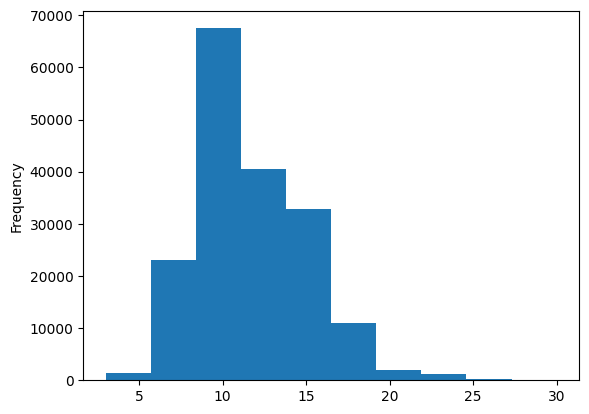

In [15]:
# Length of different lines
train_df.total_lines.plot.hist()

### Get lists of sentences

In [16]:
# Convert abstract lines into lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels

In [18]:
# One-hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label Encoded labels

In [19]:
# Extract labels and encode into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
# Get class names and number of classes
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Series of modelling experiments

## Model 0: Baseline

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [22]:
# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# Evaluate
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [24]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [25]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Download helper_function.py

In [26]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-02-13 23:26:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-02-13 23:26:40 (76.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [27]:
from helper_functions import calculate_results

In [28]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data for deep sequence models

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [30]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [32]:
# how long each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_leng = np.mean(sent_lens)
avg_sent_leng

26.338269273494777

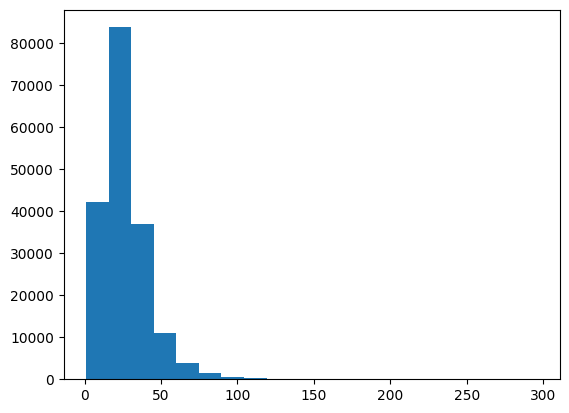

In [36]:
# What's the distribution
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [37]:
# what sentence lengths covers 95% of the data
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [38]:
# max sentence length in train set
max(sent_lens)

296

### Create text_vectorizer layer

In [39]:
# max words in vocab
max_tokens = 68000

In [40]:
# Create text vectorizer
from tensorflow.keras import layers

text_vectorizer = layers.TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                           output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [41]:
# Adapt text vectorizer to train sentences
text_vectorizer.adapt(train_sentences)

In [42]:
# test text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
intraoperative hematocrit levels were higher and need for postoperative erythrocyte transfusion was decreased in group in .

Length of text: 17

Vectorized text:
[[ 842 4372   93    9   82    3  483   11  163 3201 1082   10  212    5
    13    5    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [44]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [45]:
# Get config of text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create embedding layer

In [46]:
rct_20k_text_vocab

['',
 '[UNK]',
 'the',
 'and',
 'of',
 'in',
 'to',
 'with',
 'a',
 'were',
 'was',
 'for',
 'patients',
 'group',
 'p',
 'at',
 'or',
 'study',
 'on',
 'treatment',
 'is',
 'after',
 'by',
 'this',
 'groups',
 'as',
 'an',
 'from',
 'that',
 'randomized',
 'between',
 'not',
 'trial',
 'no',
 'compared',
 'control',
 'be',
 'significant',
 'intervention',
 'significantly',
 'n',
 'months',
 'than',
 'we',
 'vs',
 'rsb',
 'lsb',
 'clinical',
 'placebo',
 'baseline',
 'ci',
 'two',
 'during',
 'weeks',
 'both',
 'had',
 'primary',
 'mean',
 'are',
 'using',
 'participants',
 'there',
 'all',
 'time',
 'years',
 'pain',
 'therapy',
 'who',
 'mg',
 'more',
 'effect',
 'effects',
 'but',
 'risk',
 'difference',
 'outcomes',
 'total',
 'care',
 'rate',
 'efficacy',
 'received',
 'associated',
 'higher',
 'respectively',
 'days',
 'analysis',
 'outcome',
 'use',
 'one',
 'week',
 'women',
 'may',
 'randomly',
 'levels',
 'followup',
 'will',
 'increased',
 'health',
 'used',
 'have',
 'data'

In [47]:
# Create token embed layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [48]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
intraoperative hematocrit levels were higher and need for postoperative erythrocyte transfusion was decreased in group in .

Sentence after vectorization (before embedding):
[[ 842 4372   93    9   82    3  483   11  163 3201 1082   10  212    5
    13    5    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[ 0.01150029  0.00095499  0.03691227 ... -0.04694561 -0.03665593
   -0.00948181]
  [-0.04909446  0.00616964 -0.03675599 ... -0.00504468  0.01141275
    0.03178268]
  [ 0.02357272  0.04094936 -0.04376023 ...  0.00133454  0.02700329
    0.03512824]
  ...
  [ 0.02893975 -0.02359696  0.03460899 ... -0.00140206  0.04622043
   -0.0095508 ]
  [ 0.02893975 -0.02359696  0.03460899 ... -0.00140206  0.04622043
   -0.0095508 ]
  [ 0.02893975 -0.02359696  0.03460899 ... -0.00140206  0.0462

# Create datasets

In [50]:
# Trun data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [51]:
# Turn datasets into prefetch datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>